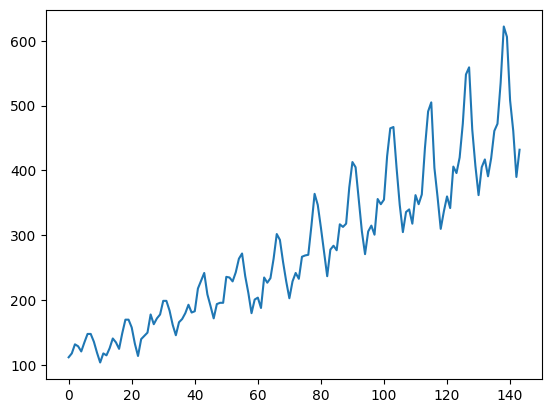

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import torch 
import torch.nn as nn 
import numpy as np
import torch.optim as optim 
import torch.utils.data as data 


df = pd.read_csv("datasets/airline.txt", sep=",")
timeseries = df[['Passengers']].values.astype("float32")
plt.plot(timeseries)


In [6]:
train_size = int(len(timeseries) * .67)
test_size = len(timeseries) - train_size
train, test = timeseries[0:train_size], timeseries[train_size:len(timeseries)]


In [8]:
def create_dataset(dataset, lookback): 
    X, y = [], []
    for i in range(len(dataset) - lookback): 
        feature = dataset[i:(i + lookback)]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)


In [17]:
loopback = 10
X_train, y_train = create_dataset(train, loopback)
X_test, y_test = create_dataset(test, loopback)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

torch.Size([86, 10, 1]) torch.Size([86, 10, 1]) torch.Size([38, 10, 1]) torch.Size([38, 10, 1])


In [18]:
class AirModel(nn.Module): 
    def __init__(self): 
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = nn.Linear(50, 1)
    
    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.linear(x)
        return x



In [19]:
model = AirModel()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), batch_size=8, shuffle=True)

n_epochs = 2000
for epoch in range(n_epochs): 
    model.train()
    for X_batch, y_batch in loader: 
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad(): 
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print(f"Epoch: {epoch}, Train RMSE: {train_rmse}, Test RMSE: {test_rmse}")

Epoch: 0, Train RMSE: 222.74179077148438, Test RMSE: 419.11041259765625
Epoch: 100, Train RMSE: 174.2221221923828, Test RMSE: 368.47265625
Epoch: 200, Train RMSE: 136.9186248779297, Test RMSE: 328.1196594238281
Epoch: 300, Train RMSE: 106.50130462646484, Test RMSE: 292.7027587890625
Epoch: 400, Train RMSE: 84.24169158935547, Test RMSE: 262.35150146484375
Epoch: 500, Train RMSE: 62.434906005859375, Test RMSE: 230.74664306640625
Epoch: 600, Train RMSE: 48.247779846191406, Test RMSE: 204.14151000976562
Epoch: 700, Train RMSE: 38.27631759643555, Test RMSE: 181.36624145507812
Epoch: 800, Train RMSE: 30.92040252685547, Test RMSE: 161.2647247314453
Epoch: 900, Train RMSE: 26.120309829711914, Test RMSE: 144.09219360351562
Epoch: 1000, Train RMSE: 22.64524269104004, Test RMSE: 129.64852905273438
Epoch: 1100, Train RMSE: 20.127967834472656, Test RMSE: 116.90328979492188
Epoch: 1200, Train RMSE: 18.240074157714844, Test RMSE: 106.26454162597656
Epoch: 1300, Train RMSE: 17.003849029541016, Test RM

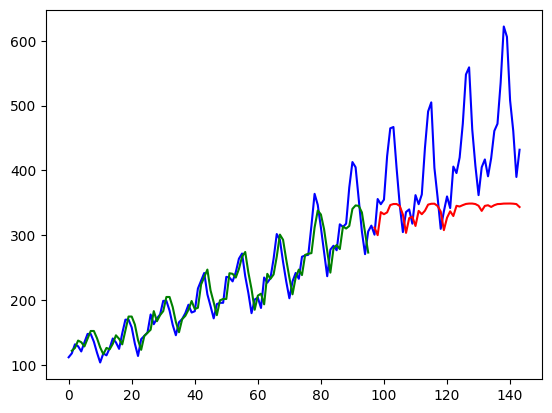

In [16]:
with torch.no_grad(): 
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[loopback:train_size] = model(X_train)[:, -1, :]
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+loopback:len(timeseries)] = model(X_test)[:, -1, :]

plt.plot(timeseries, c="b")
plt.plot(train_plot, c="g")
plt.plot(test_plot, c="r")
